# Inference Taco

In [2]:
import torch
import torchvision.transforms as T
from argparse import Namespace
import torch.optim as optim
from yolov1 import Train
from utils.checkpoints import load_checkpoint
from yolov1 import YOLOv1
torch.set_printoptions(threshold=torch.inf) # shows all the values when printing tensors in jupyter notebook


## Configurations

In [3]:
torch.manual_seed(1)

# <------------- Hyperparameters/Config ------------->
config = Namespace(
    DEVICE=torch.device("mps"),  # apple silicon M series
    NUM_WORKERS=2,
    PIN_MEMORY=True,
    EPOCHS=50,
    LEARNING_RATE=2e-5, # TODO implement a scheduled learning rate
    BATCH_SIZE=64,
    WEIGHT_DECAY=0,  # TODO play with weight decay


    # load a model with weights that u have been trained to train it more
    CON_TRAINING=True,  # continue to train a model
    LOAD_MODEL_FILE="Yolo_v1_taco_448_448_epoch_50_2025-04-27_loss_275.5003.pt", #ex: "Yolo_v1_taco_448_448_epoch_50_2025-04-27.pt"

    MODE="train", # "train", "test" or "valid"
    DATASET_DIR="./data",  # root path to the dataset dir
    IMAGE_SIZE=448,


    C=18,  # how many classes in the dataset
    B=2,  # how many bounding boxes does the model predict per cell
    S=7,  # split_size, how to split the image, 7x7=49 grid cells,
    IOU_THRESHOLD=0.5,  # the iou threshold when comparing bounding boxes for NMS
    MIN_THRESHOLD=0.4,  # the minimal confidence to keep a predicted bounding box
)
# NOTE: NUM_NODES_PER_CELL and NUM_NODES_PER_IMG could have been named better like "D" or "M" idk
# The total number of nodes that a single cell has in a label for one image, which would be the size -> [*classes, pc_1, bbox1_x_y_w_h, pc_2, bbox2_x_y_w_h]. If S=7 C=18 B=2 --> 28 nodes.
config.NUM_NODES_PER_CELL = config.C + 5 * config.B

# The total number of nodes that each label has for one image. If S=7 C=18 B=2 --> 7 * 7 * (18 + 2 * 5) = 1,372 | 7x7=49 -> 49*28 = 1,372 | the * 5 is for the second bbox in the cell -> pc_2, x, y, w, h
config.NUM_NODES_PER_IMG = config.S * config.S * (config.C + config.B * 5)


# <------------- Transforms ------------->
class Compose(object):
    """Apply a sequence of transforms safely on (image, bboxes)."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img, bboxes)
        return img, bboxes


class Resize(object):
    """Resize the image. No change needed for bboxes since they are normalized (0-1)."""

    def __init__(self, size):
        self.size = size  # (width, height) like (448,448)

    def __call__(self, img, bboxes):
        img = T.Resize(self.size)(img)
        return img, bboxes  # bboxes stay the same


class ToTensor(object):
    """Convert image to Tensor. Leave bboxes as they are."""

    def __call__(self, img, bboxes):
        img = T.ToTensor()(img)  # Automatically normalize image between 0-1
        return img, bboxes


transforms = Compose(
    # transform object to resize the bboxes and images.  Normalize image tensors
    [
        Resize((448, 448)),  # Resize image to 448x448
        ToTensor(),  # Convert image to tensor
    ]
)


## Load Dataset

In [4]:
from yolov1.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

dataset = Dataset(S=config.S, B=config.B, C=config.C, mode=config.MODE, dataset_path=config.DATASET_DIR, transforms=transforms)


CSV file already exists.


In [5]:
img_tensor, label = dataset.__getitem__(1) # grab image at index _ in dataframe
img_tensor.shape, label.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 28]))

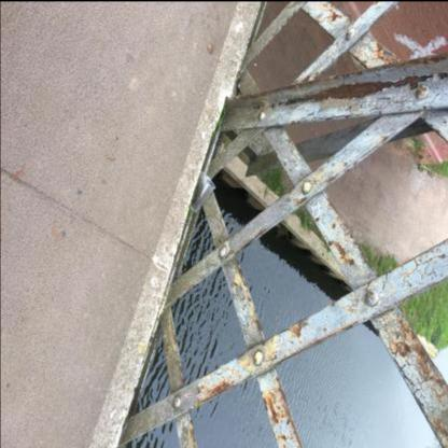

In [ ]:
img = to_pil_image(img_tensor)
img

In [ ]:
# TODO Upload a picture option

## Load Model

In [7]:
yolo = YOLOv1(in_channels=3, S=config.S, B=config.B, C=config.C).to(config.DEVICE)

optimizer = optim.Adam(
    yolo.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
if config.CON_TRAINING:
    load_checkpoint(file_name=config.LOAD_MODEL_FILE, yolo=yolo, optimizer=optimizer)



################################ 


-> Loading Model from checkpoint. Yolo_v1_taco_448_448_epoch_50_2025-04-27_loss_275.5003.pt

Loaded model.

################################ 



## Predict

In [8]:
# Add a batch to the img tensor
img_tensor = img_tensor.unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 448, 448])

In [9]:
out = yolo(img_tensor.to(config.DEVICE))

In [10]:
out, out.shape

(tensor([[ 1.0543e-01,  4.4859e-01,  4.7875e-02, -2.1051e-01,  3.6213e-01,
           3.2827e-02,  2.8682e-02,  2.1827e-02,  3.5548e-02,  8.7836e-03,
           1.3404e-01, -7.6261e-02,  1.5465e-01, -7.0032e-02, -7.0253e-02,
          -1.0769e-01,  2.6521e-01,  5.7115e-01, -1.5546e-01,  8.6339e-01,
           1.0675e+00,  1.9132e-01, -6.3582e-02, -1.0712e-01,  9.3539e-01,
           1.1748e+00,  5.8972e-02,  2.4191e-02,  1.5725e-01,  2.9523e-01,
          -4.1030e-02,  8.4946e-02,  1.7208e-01,  1.0469e-02,  4.6200e-01,
           1.2436e-01,  1.0483e-01, -1.4429e-01,  3.3997e-01,  1.5446e-01,
           2.6578e-01, -2.9634e-01,  3.1233e-01,  1.2009e-01,  5.7004e-02,
           1.5503e-01, -2.7311e-02,  6.8176e-01,  8.4759e-01,  1.8626e-01,
           3.1690e-01,  1.7762e-01,  1.0487e+00,  8.4139e-01,  2.4634e-02,
           2.3625e-01,  3.2409e-01,  3.9700e-01, -1.8211e-01, -1.1854e-01,
          -1.6914e-02, -1.1260e-01,  1.9373e-01,  2.2323e-01,  8.1007e-02,
           5.5335e-01,  1

Reshape output from (1, 1372) -> (1, 7, 7, 28)

In [11]:
# Reshape output
out = out.view(1, 7, 7, 28)
out, out.shape

(tensor([[[[ 1.0543e-01,  4.4859e-01,  4.7875e-02, -2.1051e-01,  3.6213e-01,
             3.2827e-02,  2.8682e-02,  2.1827e-02,  3.5548e-02,  8.7836e-03,
             1.3404e-01, -7.6261e-02,  1.5465e-01, -7.0032e-02, -7.0253e-02,
            -1.0769e-01,  2.6521e-01,  5.7115e-01, -1.5546e-01,  8.6339e-01,
             1.0675e+00,  1.9132e-01, -6.3582e-02, -1.0712e-01,  9.3539e-01,
             1.1748e+00,  5.8972e-02,  2.4191e-02],
           [ 1.5725e-01,  2.9523e-01, -4.1030e-02,  8.4946e-02,  1.7208e-01,
             1.0469e-02,  4.6200e-01,  1.2436e-01,  1.0483e-01, -1.4429e-01,
             3.3997e-01,  1.5446e-01,  2.6578e-01, -2.9634e-01,  3.1233e-01,
             1.2009e-01,  5.7004e-02,  1.5503e-01, -2.7311e-02,  6.8176e-01,
             8.4759e-01,  1.8626e-01,  3.1690e-01,  1.7762e-01,  1.0487e+00,
             8.4139e-01,  2.4634e-02,  2.3625e-01],
           [ 3.2409e-01,  3.9700e-01, -1.8211e-01, -1.1854e-01, -1.6914e-02,
            -1.1260e-01,  1.9373e-01,  2.2323e-01

## Compute NMS

- Remove redundant bboxes that the model predicted.

In [12]:
# For juypter notebook: reloads external functions when its code changes.
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files
%aimport utils.nms
%aimport utils.bboxes

from utils.nms import non_max_suppression
from utils.bboxes import extract_bboxes, reconstruct_tensor

In [ ]:
# remove the batch dimension, view in matrices_visualize/nms_remove_dim.py
pred_bboxes = out.squeeze() # shape -> 7, 7, 28

# Extract all bounding boxes into a tensor
bboxes = extract_bboxes(pred_bboxes, config) # (N, 9) [ i, j, b, class_idx, pc, x, y, w, h]

In [19]:
bboxes_nms = non_max_suppression(
    pred_bboxes=bboxes,
    config=config
)
bboxes_nms

tensor([[ 4.0000,  3.0000,  1.0000,  3.0000,  0.6634,  1.5319,  0.8201, -0.4227,
          0.0994],
        [ 4.0000,  4.0000,  1.0000,  4.0000,  0.5169,  0.8107,  0.7129,  0.1102,
          0.3295],
        [ 5.0000,  3.0000,  1.0000,  6.0000,  0.4997,  0.6857,  1.0047,  0.1981,
         -0.1987],
        [ 2.0000,  2.0000,  1.0000,  6.0000,  0.4560,  1.2992,  0.9592,  0.0531,
         -0.1539],
        [ 2.0000,  2.0000,  0.0000,  6.0000,  0.4379,  1.2869,  0.9326,  0.2641,
          0.0716],
        [ 6.0000,  1.0000,  1.0000,  6.0000,  0.4265,  1.0099,  0.8400, -0.0704,
          0.1760],
        [ 2.0000,  3.0000,  0.0000, 12.0000,  1.5319,  0.4145,  1.5462,  0.4156,
          0.1927],
        [ 2.0000,  3.0000,  1.0000, 12.0000,  1.2834,  0.2134,  0.9581,  0.1095,
          0.6761],
        [ 3.0000,  4.0000,  0.0000, 12.0000,  0.6845,  0.8181,  0.9912,  0.3395,
          0.3271],
        [ 3.0000,  3.0000,  1.0000, 13.0000,  0.4708,  1.2960,  0.3590,  0.2868,
          0.1866]],

In [ ]:
# Reconstruct the surviving bboxes
valid_bboxes = reconstruct_tensor(bboxes_nms, config)
valid_bboxes

tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0

## Plot The Predicted And True Bounding boxes

In [21]:
from utils.plot import plot_bboxes

In [ ]:
plot_bboxes(img=img, config=config, true_bboxes=label, pred_bboxes=valid_bboxes)